In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import cloudvolume
from caveclient import CAVEclient
import seaborn as sns
import scikit_posthocs as sp
from scipy import stats
client = CAVEclient('minnie65_phase3_v1')
from datetime import datetime, timezone
from ast import literal_eval


C:\Users\clare.gamlin\AppData\Local\anaconda3\lib\site-packages\python_jsonschema_objects\__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


In [2]:

settime = datetime(2023, 9, 19, 4, 0, 0, 0, tzinfo=timezone.utc)
df_ids_pred_met = pd.read_csv(r"C:\Users\clare.gamlin\Documents\CG_EM_paper\EM_MC_paper_figures-main-10092023\EM_MC_paper_figures-main\Final_EM_MetType_Preds_RFC_Resamp_AllFeats_NoRadius.csv")
df_ids_pred_met = df_ids_pred_met.loc[df_ids_pred_met['probability'] >0.54]

cur_ssts = client.materialize.query_table('gamlin_2023_mcs', timestamp=settime)
cur_ssts_pred = pd.merge(df_ids_pred_met, cur_ssts, left_on = 'id', right_on = 'pt_root_id')
pre_id_mc = cur_ssts_pred["id_x"]
print (cur_ssts_pred.head(18))
print (pre_id_mc)

    Unnamed: 0                id_x predicted_MET-type Label  probability  \
0            3  864691135013417622                Sst-MET-4        1.000   
1           10  864691135118298333                Sst-MET-4        0.790   
2           29  864691135341516741                Sst-MET-9        0.878   
3           39  864691135404765166                Sst-MET-6        0.982   
4           61  864691135544588584                Sst-MET-8        1.000   
5           72  864691135572082925                Sst-MET-8        1.000   
6           75  864691135577202181                Sst-MET-4        0.998   
7           86  864691135697251738                Sst-MET-6        0.980   
8           89  864691135699487522                Sst-MET-8        1.000   
9           98  864691135785592004                Sst-MET-4        0.994   
10         117  864691135969447781                Sst-MET-4        1.000   
11         136  864691136116457636                Sst-MET-6        0.994   
12         1

In [3]:
df2 = client.materialize.synapse_query(pre_ids= pre_id_mc, timestamp = settime)
print (df2.shape)

(67311, 12)


In [4]:
md3 = client.materialize.query_table('aibs_metamodel_celltypes_v661', timestamp = settime) ##Leila's new model as of 12/23/23
soma_counts = md3['pt_root_id'].value_counts().rename_axis('pt_root_id').reset_index(name ='no_of_somas')
dfm = pd.merge(df2, md3, left_on = 'post_pt_root_id', right_on ='pt_root_id', how = 'right')
singlesomas = soma_counts.loc[soma_counts['no_of_somas'] == 1]
single_soma_merge = pd.merge(md3, singlesomas, left_on = 'pt_root_id', right_on = 'pt_root_id', how = 'inner')
dfm_somas = pd.merge(df2, single_soma_merge, left_on = 'post_pt_root_id', right_on = 'pt_root_id', how = 'inner')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('1P','23P')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('BC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('MC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('NGC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('BPC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('6P-CT','6P')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('6P-IT','6P')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('OPC','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('astrocyte','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('oligo','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('microglia','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('pericyte','Glia')

# dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('5P-PT','5P-ET')
print (dfm_somas.tail())

            id_x                        created_x  superceded_id valid_x  \
56771  160232162 2020-11-04 09:47:53.548995+00:00            NaN       t   
56772  239969322 2020-11-04 10:25:48.305606+00:00            NaN       t   
56773  241743371 2020-11-04 07:08:54.370844+00:00            NaN       t   
56774  264496899 2020-11-04 09:02:52.594441+00:00            NaN       t   
56775  264366678 2020-11-04 12:15:43.025763+00:00            NaN       t   

       size  pre_pt_supervoxel_id      pre_pt_root_id  post_pt_supervoxel_id  \
56771   532     89237670051615780  864691135969447781      89167301307443076   
56772   956     96202663561134721  864691135118298333      96202663561129412   
56773  1480     96000010629529047  864691135118298333      96000010629524077   
56774   632     97825199193851624  864691135118298333      97825199193826925   
56775  2156     97396390329644066  864691136116457636      97396390329649945   

          post_pt_root_id          pre_pt_position  ...  id_re

In [5]:
dfm_somas = dfm_somas.loc[(dfm_somas['cell_type'] != 'Glia')]
print (dfm_somas.shape[0])


56663


In [6]:
cur_ssts_pred_sub = cur_ssts_pred[['id_x', 'predicted_MET-type Label', 'probability']]
cur_ssts_pred_sub = cur_ssts_pred_sub.sort_values(by=['probability'], ascending = False)
cur_ssts_pred_rename = cur_ssts_pred_sub.rename(columns = {"id_x": "Cell ID", "probability": "Reliability","predicted_MET-type Label": "Predicted MET-type"})
print (cur_ssts_pred_rename.head(16))
allmcs = cur_ssts_pred_rename["Cell ID"]
met8_pred = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['Predicted MET-type'] == "Sst-MET-8"]
met8_id = met8_pred["Cell ID"]

met4_pred = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['Predicted MET-type'] == "Sst-MET-4"]
met4_id = met4_pred["Cell ID"]

met6_pred = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['Predicted MET-type'] == "Sst-MET-6"]
met6_id = met6_pred["Cell ID"]

###calculate the fraction of synapes that have an analyzed postsynaptic target - separated by MET-type
##MET-6

# frac_syn = []
# for i in met6_id:
# #     print (i)
#     df3 = client.materialize.synapse_query(pre_ids= i, timestamp = settime)
#     orig = df3.shape[0]
#     dfm_i = dfm_somas.loc[dfm_somas['pre_pt_root_id'] == i]
#     filt = dfm_i.shape[0]
#     frac = (filt/orig)
#     frac_syn = np.append(frac_syn, frac)
# print (frac_syn)
# print(frac_syn.mean())
# met6_pred ['Fraction of synapses analyzed'] = frac_syn
# summary_df = pd.DataFrame([['Average', '-', '-', frac_syn.mean()]], columns=list(['Cell ID', 'Predicted MET-type','Reliability', 'Fraction of synapses analyzed']))
# std_df = pd.DataFrame([['Std Dev', '-', '-', frac_syn.std()]], columns=list(['Cell ID', 'Predicted MET-type','Reliability', 'Fraction of synapses analyzed']))

# met6_pred_concat = pd.concat([met6_pred, summary_df, std_df])
# met6_round = met6_pred_concat.round(3)
# print (met6_round.head())
# fix, ax1 = plt.subplots()
# ax1.axis('off')
# table = pd.plotting.table(ax1, met6_round, colLabels = ['Cell ID', 'Predicted MET-type', 'Reliability', 'Fraction of synapses analyzed'], loc='center',
#                           cellLoc='center', colWidths = list([ 0.3, 0.3, 0.3, 0.4]))

# # plt.savefig('met6_frac_syn_analyzed_std.pdf', bbox_inches = 'tight')
# plt.show()

##MET-4

# frac_syn = []
# for i in met4_id:
# #     print (i)
#     df3 = client.materialize.synapse_query(pre_ids= i, timestamp = settime)
#     orig = df3.shape[0]
#     dfm_i = dfm_somas.loc[dfm_somas['pre_pt_root_id'] == i]
#     filt = dfm_i.shape[0]
#     frac = (filt/orig)
#     frac_syn = np.append(frac_syn, frac)
# print (frac_syn)
# print(frac_syn.mean())
# met4_pred['Fraction of synapses analyzed'] = frac_syn
# summary_df = pd.DataFrame([['Average', '-', '-', frac_syn.mean()]], columns=list(['Cell ID', 'Predicted MET-type','Reliability', 'Fraction of synapses analyzed']))
# std_df = pd.DataFrame([['Std Dev', '-', '-', frac_syn.std()]], columns=list(['Cell ID', 'Predicted MET-type','Reliability', 'Fraction of synapses analyzed']))
# met4_pred_concat = pd.concat([met4_pred, summary_df, std_df])

# # met4_pred_concat.style \
# #   .format(precision=2, decimal=".") \
# #   .format_index(str.upper, axis=1) \
# #   .hide()\
# #   .relabel_index(["Cell ID", "Predicted MET-Type Label", "Probability", "Fraction of synapses analyzed"], axis = 1)
# # style_met4.to_html()
# met4_round = met4_pred_concat.round(3)
# fix, ax2 = plt.subplots()
# ax2.axis('off')
# table = pd.plotting.table(ax2, met4_round, colLabels = ['Cell ID', 'Predicted MET-type', 'Reliability', 'Fraction of synapses analyzed'], loc='center',
#                           cellLoc='center', colWidths = list([ 0.3, 0.3, 0.3, 0.4]))

# plt.savefig('met4_frac_syn_analyzed_std.pdf', bbox_inches = 'tight')
# # plt.show()

##MET-8 

# frac_syn = []
# for i in met8_id:
# #     print (i)
#     df3 = client.materialize.synapse_query(pre_ids= i, timestamp = settime)
#     orig = df3.shape[0]
#     dfm_i = dfm_somas.loc[dfm_somas['pre_pt_root_id'] == i]
#     filt = dfm_i.shape[0]
#     frac = (filt/orig)
#     frac_syn = np.append(frac_syn, frac)
# print (frac_syn)
# print(frac_syn.mean())
# # print(frac_syn.std())
# met8_pred ['Fraction of synapses analyzed'] = frac_syn
# summary_df = pd.DataFrame([['Average', '-', '-', frac_syn.mean()]], columns=list(['Cell ID', 'Predicted MET-type','Reliability', 'Fraction of synapses analyzed']))
# std_df = pd.DataFrame([['Std Dev', '-', '-', frac_syn.std()]], columns=list(['Cell ID', 'Predicted MET-type','Reliability', 'Fraction of synapses analyzed']))

# met8_pred_concat = pd.concat([met8_pred, summary_df, std_df])
# met8_round = met8_pred_concat.round(3)
# print (met8_round.head())
# fix, ax3 = plt.subplots()
# ax3.axis('off')
# table = pd.plotting.table(ax3, met8_round, colLabels = ['Cell ID', 'Predicted MET-type', 'Reliability', 'Fraction of synapses analyzed'], loc='center',
#                           cellLoc='center', colWidths = list([ 0.3, 0.3, 0.3, 0.4]))

# # plt.savefig('met8_frac_syn_analyzed_std.pdf', bbox_inches = 'tight')
# # plt.show()
# print (met8_pred_concat)
# # print (frac_syn.mean()


##MET-5 & 9

# met5_pred = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['Predicted MET-type'] == "Sst-MET-5"]
# met5_id = met5_pred["Cell ID"]

# met9_pred = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['Predicted MET-type'] == "Sst-MET-9"]
# met9_id = met9_pred["Cell ID"]

# frac_syn = []
# for i in met9_id:
# #     print (i)
#     df3 = client.materialize.synapse_query(pre_ids= i, timestamp = settime)
#     orig = df3.shape[0]
#     dfm_i = dfm_somas.loc[dfm_somas['pre_pt_root_id'] == i]
#     filt = dfm_i.shape[0]
#     frac = (filt/orig)
#     frac_syn = np.append(frac_syn, frac)
# print (frac_syn)
# print(frac_syn.mean())
# # print(frac_syn.std())
# met9_pred ['Fraction of synapses analyzed'] = frac_syn

# met_pred_concat = pd.concat([met9_pred])
# met_round = met_pred_concat.round(3)
# print (met_round.head())
# fix, ax3 = plt.subplots()
# ax3.axis('off')
# table = pd.plotting.table(ax3, met_round, colLabels = ['Cell ID', 'Predicted MET-type', 'Reliability', 'Fraction of synapses analyzed'], loc='center',
#                           cellLoc='center', colWidths = list([ 0.3, 0.3, 0.3, 0.4]))

# plt.savefig('met9_frac_syn_analyzed_std.pdf', bbox_inches = 'tight')
# plt.show()
# print (met_pred_concat)
# print (frac_syn.mean()


# ####compare number of synapses versus axon length

# em_features = pd.read_csv(r"C:\Users\clare.gamlin\Documents\CG_EM_paper\EM_MC_paper_figures-main-10092023\EM_MC_paper_figures-main\173_inhib_column_paper_RawFeatureWide_resamp_1550.csv")
# em_features_axonlen = em_features[["specimen_id", "axon_total_length"]]
# # print (em_features_axonlen.head())
# frac_syn = []
# axon_len = []
# total_syn = []
# for i in allmcs:
#     print (i)
#     df3 = client.materialize.synapse_query(pre_ids= i, timestamp = settime)
#     orig = df3.shape[0]
# #     print (orig)
#     emfeat_i = em_features_axonlen.loc[em_features_axonlen['specimen_id'] == i]
#     tot_axon_len = emfeat_i['axon_total_length']
#     np_axon_len = tot_axon_len.to_numpy()
# #     print (np_axon_len)
# #     filt = dfm_i.shape[0]
#     frac = (orig/np_axon_len)
#     frac_syn = np.append(frac_syn, frac)
#     axon_len = np.append(axon_len, np_axon_len)
#     total_syn = np.append(total_syn, orig)
# #     print ('syn/axon length')
# #     print (frac)
# print (frac_syn)
# print(frac_syn.mean())
# cur_ssts_pred_rename['Total_syn'] = total_syn
# cur_ssts_pred_rename['Axonleng'] = axon_len
# cur_ssts_pred_rename['Syn_per_axonleng'] = frac_syn

# print (cur_ssts_pred_rename.tail(16))


               Cell ID Predicted MET-type  Reliability
0   864691135013417622          Sst-MET-4        1.000
4   864691135544588584          Sst-MET-8        1.000
5   864691135572082925          Sst-MET-8        1.000
8   864691135699487522          Sst-MET-8        1.000
10  864691135969447781          Sst-MET-4        1.000
12  864691136118647832          Sst-MET-4        1.000
6   864691135577202181          Sst-MET-4        0.998
15  864691136618564493          Sst-MET-6        0.996
9   864691135785592004          Sst-MET-4        0.994
11  864691136116457636          Sst-MET-6        0.994
14  864691136238652476          Sst-MET-6        0.992
3   864691135404765166          Sst-MET-6        0.982
13  864691136195284556          Sst-MET-5        0.982
7   864691135697251738          Sst-MET-6        0.980
2   864691135341516741          Sst-MET-9        0.878
1   864691135118298333          Sst-MET-4        0.790


In [7]:

# ####compare number of synapses versus axon length

em_features = pd.read_csv(r"C:\Users\clare.gamlin\Documents\CG_EM_paper\EM_MC_paper_figures-main-10092023\EM_MC_paper_figures-main\173_inhib_column_paper_RawFeatureWide_resamp_1550.csv")
em_features_axonlen = em_features[["specimen_id", "axon_total_length"]]
# print (em_features_axonlen.head())
frac_syn = []
axon_len = []
total_syn = []
for i in allmcs:
    print (i)
    df3 = client.materialize.synapse_query(pre_ids= i, timestamp = settime)
    orig = df3.shape[0]
#     print (orig)
    emfeat_i = em_features_axonlen.loc[em_features_axonlen['specimen_id'] == i]
    tot_axon_len = emfeat_i['axon_total_length']
    np_axon_len = tot_axon_len.to_numpy()
#     print (np_axon_len)
#     filt = dfm_i.shape[0]
    frac = (orig/np_axon_len)
    frac_syn = np.append(frac_syn, frac)
    axon_len = np.append(axon_len, np_axon_len)
    total_syn = np.append(total_syn, orig)
#     print ('syn/axon length')
#     print (frac)
print (frac_syn)
print(frac_syn.mean())
cur_ssts_pred_rename['Total_syn'] = total_syn
cur_ssts_pred_rename['Axonleng'] = axon_len
cur_ssts_pred_rename['Syn_per_axonleng'] = frac_syn

print (cur_ssts_pred_rename.tail(16))


864691135013417622
864691135544588584
864691135572082925
864691135699487522
864691135969447781
864691136118647832
864691135577202181
864691136618564493
864691135785592004
864691136116457636
864691136238652476
864691135404765166
864691136195284556
864691135697251738
864691135341516741
864691135118298333
[0.26971856 0.51516128 0.50244446 0.58747087 0.19594429 0.23324393
 0.28230767 0.23477209 0.21989961 0.20823297 0.23502044 0.25527219
 0.22898429 0.24799807 0.22990439 0.33954079]
0.29911974296372246
               Cell ID Predicted MET-type  Reliability  Total_syn  \
0   864691135013417622          Sst-MET-4        1.000     2359.0   
4   864691135544588584          Sst-MET-8        1.000    10043.0   
5   864691135572082925          Sst-MET-8        1.000     9483.0   
8   864691135699487522          Sst-MET-8        1.000    14019.0   
10  864691135969447781          Sst-MET-4        1.000     3783.0   
12  864691136118647832          Sst-MET-4        1.000     3235.0   
6   864691135

        pre_pt_root_id cell_type  size
0   864691135013417622       23P   876
1   864691135013417622        4P   431
2   864691135013417622     5P-ET    25
3   864691135013417622     5P-IT   189
4   864691135013417622     5P-NP     1
5   864691135013417622        6P   287
6   864691135013417622       INH    87
7   864691135118298333       23P  1121
8   864691135118298333        4P   259
9   864691135118298333     5P-ET   408
10  864691135118298333     5P-IT   210
11  864691135118298333     5P-NP     1
12  864691135118298333        6P    99
13  864691135118298333       INH   133
14  864691135577202181       23P  1028
15  864691135577202181        4P   602
16  864691135577202181     5P-ET    17
17  864691135577202181     5P-IT   412
18  864691135577202181     5P-NP     1
19  864691135577202181        6P    28
20  864691135577202181       INH   152
21  864691135785592004       23P   578
22  864691135785592004        4P    57
23  864691135785592004     5P-ET   394
24  864691135785592004   

<Figure size 640x480 with 0 Axes>

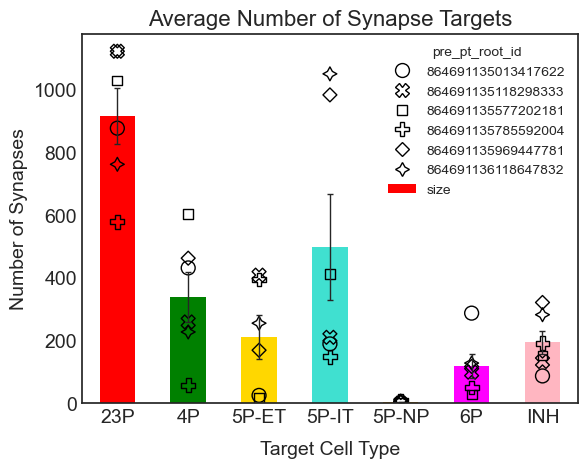

In [8]:
###get IDs for each predicted MET-type
met8_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-8"]
met8_id = met8_pred["id"]

met4_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-4"]
met4_id = met4_pred["id"]

met6_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-6"]
met6_id = met6_pred["id"]

###filter dfm somas by each met-type
met8 = dfm_somas[dfm_somas.pre_pt_root_id.isin(met8_id)]
met4 = dfm_somas[dfm_somas.pre_pt_root_id.isin(met4_id)]
met6 = dfm_somas[dfm_somas.pre_pt_root_id.isin(met6_id)]


### count # of synapses onto each cell type by MET type
met8_pre_celltypes = met8.groupby(['pre_pt_root_id', 'cell_type'], dropna = False, as_index = False).size()
met4_pre_celltypes = met4.groupby(['pre_pt_root_id', 'cell_type'], dropna = False, as_index = False).size()
met6_pre_celltypes = met6.groupby(['pre_pt_root_id', 'cell_type'], dropna = False, as_index = False).size()
d = {'pre_pt_root_id': [864691135404765166], 'cell_type': ['5P-NP'],  'size':[0]}
add0 = pd.DataFrame(data = d)
met6_pre_celltypes = pd.concat([met6_pre_celltypes, add0]) 

met8_pre_celltypes = met8_pre_celltypes.sort_values(by = ['pre_pt_root_id', 'cell_type'])
met4_pre_celltypes = met4_pre_celltypes.sort_values(by = ['pre_pt_root_id', 'cell_type'])
met6_pre_celltypes = met6_pre_celltypes.sort_values(by = ['pre_pt_root_id', 'cell_type'])


###calc mean # of syn onto cell types by MET type
met8_no_mean =met8_pre_celltypes.groupby('cell_type', as_index = False).mean()
met8_no_sem =met8_pre_celltypes.groupby('cell_type', as_index = False).sem()
met8_no_mean['sem'] = met8_no_sem['size']

met4_no_mean =met4_pre_celltypes.groupby('cell_type', as_index = False).mean()
met4_no_sem =met4_pre_celltypes.groupby('cell_type', as_index = False).sem()
met4_no_mean['sem'] = met4_no_sem['size']

met6_no_mean =met6_pre_celltypes.groupby('cell_type', as_index = False).mean()
met6_no_sem =met6_pre_celltypes.groupby('cell_type', as_index = False).sem()
met6_no_mean['sem'] = met6_no_sem['size']

print(met4_pre_celltypes)

###plot number of synapses onto each cell type

##plotting cell with n > 1, so can calc SEM
plotting_met_mean = met4_no_mean
plotting_met_all = met4_pre_celltypes
with plt.style.context('seaborn-white', after_reset = True):
    afont = {'fontname':'Arial'}
    fig = plt.figure()
    my_color = ["red", "green", "gold", "turquoise", "orange", "magenta", "lightpink"]

    ####number of syn
    ax = plotting_met_mean.plot(kind = 'bar', x = 'cell_type', y = 'size', color = my_color, linewidth = 3, yerr = 'sem', error_kw=dict(lw=1, capsize=2, capthick=1))
    sns.scatterplot(x = "cell_type", y = "size", style = "pre_pt_root_id", data = plotting_met_all, edgecolor = "black", linewidth = 1, s = 100, color = 'None', ax = ax)
    ax.set_ylabel('Number of Synapses', fontsize =14, **afont)
    plt.title('Average Number of Synapse Targets', fontsize = 16, **afont)
    ax.set_xlabel('Target Cell Type', fontsize =14, **afont)
    plt.xticks (fontsize =14, rotation = 0, **afont)
    plt.yticks (fontsize =14, **afont, visible = True)
#     ax.get_legend().remove()
    ax.xaxis.labelpad = 10
#     plt.savefig('__.png', bbox_inches = 'tight')

    plt.show()
    

met_type          MET8        MET4   MET6
cell_type                                
23P        1087.000000  914.166667  529.2
4P         6355.000000  339.666667   97.4
5P-ET        90.333333  211.333333  447.0
5P-IT      1206.666667  498.333333  132.0
5P-NP         4.333333    3.833333    1.8
6P          132.333333  118.166667  163.4
INH         745.666667  194.333333  128.4


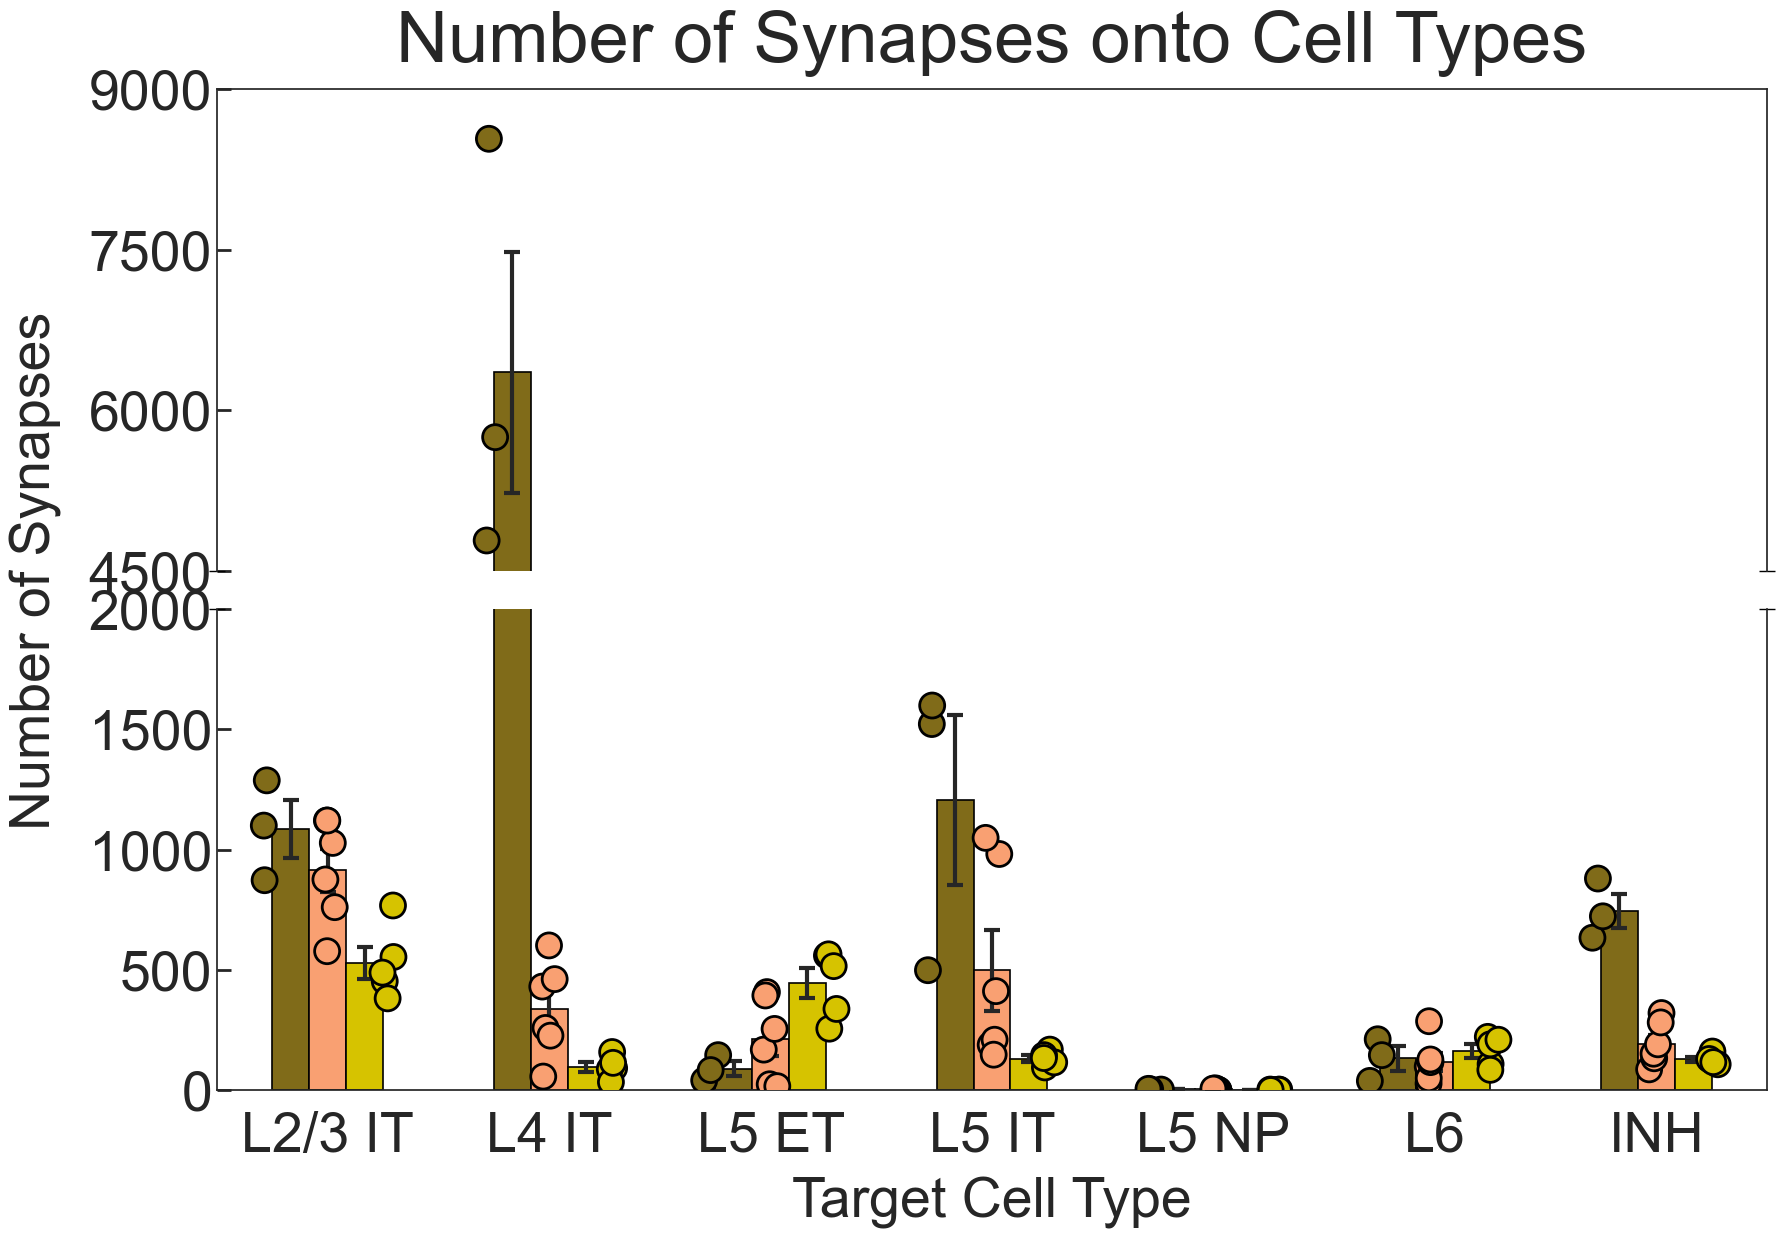

In [9]:
####comparing total syn onto group across MET types -single plot (all MET types n > 1)

##note all of these cells as MET-type
met8_pre_celltypes["met_type"] = "MET8"
met4_pre_celltypes["met_type"] = "MET4"
met6_pre_celltypes["met_type"] = "MET6"

##merge into one table for calculating % and # of syn onto cell types
met846_celltypes = pd.concat([met8_pre_celltypes, met4_pre_celltypes, met6_pre_celltypes])

###number of synapses met 846
met846_mean =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['size'].mean()
met846_sem =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['size'].sem()
met846_mean['sem'] = met846_sem['size']
# print (met846_mean)
met846_mean_table = pd.pivot(met846_mean, values = 'size', index = ['cell_type'], columns =['met_type'])
met846_mean_table = met846_mean_table[["MET8", "MET4", "MET6"]]
# met846_mean_table = met846_mean_table.reset_index()
print (met846_mean_table)
met846_sem_table = pd.pivot(met846_mean, values = 'sem', index = ['cell_type'], columns =['met_type'])
met846_sem_table = met846_sem_table[["MET8", "MET4", "MET6"]]



with plt.style.context('seaborn-white', after_reset = True):
    fig, (ax10, ax20) = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0.08)  # adjust space between axes
    fig.set_figwidth(20)
    fig.set_figheight(13)
    afont = {'fontname':'Arial'}
#     met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
    met_color = ['#806B19', '#f9a072','#D6C300']


    ###percent of syn
#     plt.rcParams['figure.figsize'] = [5, 3.6]

    met846_mean_table.plot(kind = 'bar', linewidth = 1.2, edgecolor = 'black', color = met_color , yerr = met846_sem_table, error_kw=dict(lw=3, capsize=6, capthick=3), legend = False, ax = ax10)
    met846_mean_table.plot(kind = 'bar', linewidth = 1.2, edgecolor = 'black', color = met_color , yerr = met846_sem_table, error_kw=dict(lw=3, capsize=6, capthick=3), legend = False, ax = ax20)

    sns.stripplot(x = "cell_type", y = "size", hue = "met_type", data = met846_celltypes, palette = met_color, edgecolor = "black", dodge = True, linewidth = 2, s = 18, marker = "o", ax = ax10)   
    sns.stripplot(x = "cell_type", y = "size", hue = "met_type", data = met846_celltypes, palette = met_color, edgecolor = "black", dodge = True, linewidth = 2, s = 18, marker = "o", ax = ax20)   
    ax10.set_ylim(4500, 9000)  # outliers only
    ax20.set_ylim(0,2000)  # most of the data

    # hide the spines between ax and ax2
    ax10.spines['bottom'].set_visible(False)
    ax20.spines['top'].set_visible(False)
    ax10.xaxis.tick_top()
    ax10.tick_params(labeltop=False)  # don't put tick labels at the top
    ax20.xaxis.tick_bottom()
    d = 0  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax10.plot([0, 1], [0, 0], transform=ax10.transAxes, **kwargs)
    ax20.plot([0, 1], [1, 1], transform=ax20.transAxes, **kwargs)
    ax10.set_title('Number of Synapses onto Cell Types', fontsize = 52, **afont, pad = 20)
    ax10.set_ylabel('Number of Synapses', fontsize =40, **afont)
    ax10.yaxis.set_label_coords(-.1, 0)
    ax20.set_ylabel('', fontsize =40, **afont)

    ax20.set_xlabel('Target Cell Type', fontsize =40, **afont)
    ax20.xaxis.labelpad = 10
    plt.xticks (fontsize =40, rotation = 0, **afont)
    plt.sca(ax10)
    plt.yticks (fontsize = 40,  **afont)
    plt.sca(ax20)
    plt.yticks (fontsize =40,  **afont)
    ax10.yaxis.labelpad = 10

#     ax20.set_xticklabels(["23P", "4P", "5P-IT", "5P-NP", "5P-ET", "6P", "INH"])
    ax10.tick_params('y', length=10, width=2, which='major', direction = "in")
    ax20.tick_params('y', length=10, width=2, which='major', direction = "in")
    ax10.yaxis.set_major_locator(ticker.MultipleLocator(1500))
    ax10.yaxis.set_major_formatter('{x:.0f}')
    ax20.yaxis.set_major_locator(ticker.MultipleLocator(500))
    ax20.yaxis.set_major_formatter('{x:.0f}')
    ax10.get_legend().remove()
    ax20.get_legend().remove()
    ax10.set_xticklabels(["L2/3 IT", "L4 IT", "L5 ET", "L5 IT", "L5 NP", "L6", "INH"])
    ax20.tick_params(axis='x', which='major', pad=15)

#     plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/No_syn_3mettype_02222024.pdf', bbox_inches = 'tight')

plt.show()

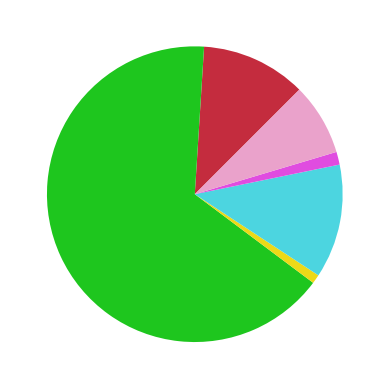

In [10]:
##calculate percentage & sem for each predicted met type

met8_pre_celltypes['percent'] = met8_pre_celltypes['size']/met8_pre_celltypes.groupby('pre_pt_root_id')['size'].transform('sum')
met8_syn_per_mean =met8_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].mean()
met8_syn_per_sem =met8_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].sem()
met8_syn_per_mean['sem'] = met8_syn_per_sem['percent']

met4_pre_celltypes['percent'] = met4_pre_celltypes['size']/met4_pre_celltypes.groupby('pre_pt_root_id')['size'].transform('sum')
met4_syn_per_mean =met4_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].mean()
met4_syn_per_sem =met4_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].sem()
met4_syn_per_mean['sem'] = met4_syn_per_sem['percent']

met6_pre_celltypes['percent'] = met6_pre_celltypes['size']/met6_pre_celltypes.groupby('pre_pt_root_id')['size'].transform('sum')
met6_syn_per_mean =met6_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].mean()
met6_syn_per_sem =met6_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].sem()
met6_syn_per_mean['sem'] = met6_syn_per_sem['percent']

### plot percentage of synapses by MET-type (change met type below)
plotting_met_mean = met8_syn_per_mean


plotting_met_mean = plotting_met_mean.loc[plotting_met_mean['cell_type'] != '5P-NP']
with plt.style.context('seaborn-white', after_reset = True):
    afont = {'fontname':'Arial'}
    fig = plt.figure()
    label = ["L2/3", "L4", "L5 ET", "L5 IT", "L6", "INH"]
# #     order1 = ["23P", "4P", "5P_IT", "5P_NP", "5P_PT", "6P", "INH"]
    my_color = ["red", "green", "gold", "turquoise", "magenta", "lightpink"]
    muted_colors2 = ['#C42C3E','#1EC61E','#EDD918', '#4CD5E0', '#E04CE0', '#EAA2CB']
#     plt.pie(plotting_met_mean['percent'], startangle = 45, explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05], colors= muted_colors2, wedgeprops={'alpha':1}, labels =label, textprops={'fontsize': 20}, pctdistance = 0.70)
    plt.pie(plotting_met_mean['percent'], startangle = 45, colors= muted_colors2, wedgeprops={'alpha':1}, textprops={'fontsize': 20}, pctdistance = 0.70)

#     plt.savefig('met8_pie_summarynolabel_july2024.pdf', bbox_inches = 'tight', transparent = True)
plt.show()


met8_syn_per_mean
  cell_type   percent       sem
0       23P  0.114938  0.010778
1        4P  0.657429  0.040411
2     5P-ET  0.009819  0.003955
3     5P-IT  0.124546  0.035351
4     5P-NP  0.000445  0.000036
5        6P  0.014047  0.006131
6       INH  0.078775  0.005007
met4_syn_per_mean
  cell_type   percent       sem
0       23P  0.410419  0.033467
1        4P  0.146892  0.035441
2     5P-ET  0.104546  0.043254
3     5P-IT  0.196309  0.050880
4     5P-NP  0.001865  0.000825
5        6P  0.054564  0.019994
6       INH  0.085406  0.013521
met6_syn_per_mean
  cell_type   percent       sem
0       23P  0.349984  0.020414
1        4P  0.065883  0.013523
2     5P-ET  0.293864  0.028380
3     5P-IT  0.090622  0.010368
4     5P-NP  0.001249  0.000432
5        6P  0.111589  0.020959
6       INH  0.086809  0.006400
  cell_type   percent       sem
0       23P  0.410419  0.033467
1        4P  0.146892  0.035441
2     5P-ET  0.104546  0.043254
3     5P-IT  0.196309  0.050880
4     5P-NP  0.001

<Figure size 640x480 with 0 Axes>

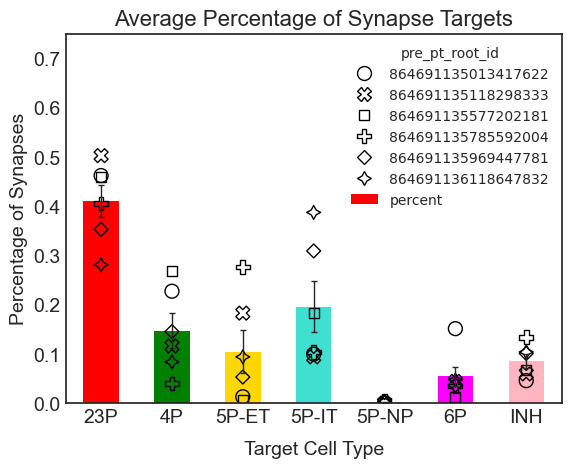

In [11]:
 ##plotting % cell with n > 1, so can calc SEM
print ('met8_syn_per_mean')
print (met8_syn_per_mean)
print ('met4_syn_per_mean')
print (met4_syn_per_mean)
print ('met6_syn_per_mean')
print (met6_syn_per_mean)
plotting_met_mean = met4_syn_per_mean
print (plotting_met_mean)
plotting_met_all = met4_pre_celltypes
with plt.style.context('seaborn-white', after_reset = True):
    afont = {'fontname':'Arial'}
    fig = plt.figure()
    my_color = ["red", "green", "gold", "turquoise", "orange", "magenta", "lightpink"]
    ####% of syn
    ax = plotting_met_mean.plot(kind = 'bar', x = 'cell_type', y = 'percent', color = my_color, linewidth = 3, yerr = 'sem', error_kw=dict(lw=1, capsize=2, capthick=1))
    sns.scatterplot(x = "cell_type", y = "percent", style = "pre_pt_root_id", data = plotting_met_all, edgecolor = "black", linewidth = 1, s = 100, color = 'None', ax = ax)
    ax.set_ylabel('Percentage of Synapses', fontsize =14, **afont)
    plt.title('Average Percentage of Synapse Targets', fontsize = 16, **afont)
    ax.set_xlabel('Target Cell Type', fontsize =14, **afont)
    ax.set_ylim(0, 0.75)
    plt.xticks (fontsize =14, rotation = 0, **afont)
    plt.yticks (fontsize =14, **afont, visible = True)
#     ax.get_legend().remove()
    ax.xaxis.labelpad = 10
#     plt.savefig('met4_percent_targets_percell.png', bbox_inches = 'tight')
plt.show()

In [12]:
####comparing % and total syn onto group across MET types -single plot

##note all of these cells as MET-type
met8_pre_celltypes["met_type"] = "MET8"
met4_pre_celltypes["met_type"] = "MET4"
met6_pre_celltypes["met_type"] = "MET6"
# met5_pre_celltypes["met_type"] = "MET5"
##merge into one table for calculating % and # of syn onto cell types
met846_celltypes = pd.concat([met8_pre_celltypes, met4_pre_celltypes, met6_pre_celltypes], ignore_index = True)
print (met846_celltypes.head())
# ###percentage of syn
met846_mean =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['percent'].mean()
met846_sem =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['percent'].sem()
met846_mean['sem'] = met846_sem['percent']

met846_per_mean_table = pd.pivot(met846_mean, values = 'percent', index = ['cell_type'], columns =['met_type'])
met846_per_mean_table = met846_per_mean_table[["MET8", "MET4", "MET6"]]
met846_per_mean_table = met846_per_mean_table.reset_index()
met846_per_sem_table = pd.pivot(met846_mean, values = 'sem', index = ['cell_type'], columns =['met_type'])
met846_per_sem_table = met846_per_sem_table[["MET8", "MET4", "MET6"]]
met846_per_sem_table = met846_per_sem_table.reset_index()

with plt.style.context('seaborn-white', after_reset = True):
    fig, ax = plt.subplots()
    fig.set_figwidth(19.2)
    fig.set_figheight(12.6)
    afont = {'fontname':'Arial'}

    met_color = ['#806B19', '#f9a072','#D6C300']
    met846_per_mean_table.plot(kind = 'bar', linewidth = 1.2, edgecolor = 'black', color = met_color, yerr = met846_per_sem_table, error_kw=dict(lw=3, capsize=6, capthick=3), legend = False, ax = ax)
    sns.stripplot(x = "cell_type", y = "percent", hue = "met_type", data = met846_celltypes, palette = met_color, edgecolor = "black", dodge = True, linewidth = 2, s = 18, marker = "o", ax = ax)   

    ax.set_ylabel('Percent of Synapses', fontsize =40, **afont)
    plt.ylim(0, 0.8)    
    plt.title('Percentage of Synapses onto Cell Types', fontsize = 52, **afont, pad = 20)
    ax.set_xlabel('Target Cell Type', fontsize =40, **afont)
    plt.xticks (fontsize =40, rotation = 0, **afont)
    ax.tick_params('y', length=10, width=2, which='major', direction = "in")
    ax.set_xticklabels(["L2/3 IT", "L4 IT", "L5 ET", "L5 IT", "L5 NP", "L6", "INH"])

    plt.yticks (fontsize =40, **afont, visible = True)
#     ax.get_legend().remove()
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 20
    ax.tick_params(axis='x', which='major', pad=15)
#     plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/Percent_syn_3mettype_02222024.pdf', bbox_inches = 'tight')
# plt.show()

       pre_pt_root_id cell_type  size met_type   percent
0  864691135544588584       23P  1100     MET8  0.136426
1  864691135544588584        4P  5747     MET8  0.712762
2  864691135544588584     5P-ET    41     MET8  0.005085
3  864691135544588584     5P-IT   499     MET8  0.061888
4  864691135544588584     5P-NP     3     MET8  0.000372


In [12]:
###STATS
####stats comparing % and # onto cell types by MET type

cell_list = ["23P", "4P",  "5P-ET", "5P-IT", "5P-NP", "6P", "INH"]
for x in range(len(cell_list)):
    print(cell_list[x])
    cell_type_x = met846_celltypes.loc[met846_celltypes['cell_type'] == cell_list[x]]

    cell_type_8 = cell_type_x.loc[cell_type_x['met_type'] == "MET8"]
    cell_type_4 = cell_type_x.loc[cell_type_x['met_type'] == "MET4"]
    cell_type_6 = cell_type_x.loc[cell_type_x['met_type'] == "MET6"]

#     ###percent
    met8_per = cell_type_8['percent']
    np_met8 = met8_per.to_numpy()
    print ('met8', np_met8)
#     print (np_met8)
    met4_per = cell_type_4['percent']
    np_met4 = met4_per.to_numpy()
    print ('met4',np_met4)
    met6_per = cell_type_6['percent']
    np_met6 = met6_per.to_numpy()
    print ('met6', np_met6)
    print (" ")


###846 
    print ('percent stats')
    stats1 = stats.kruskal(np_met8, np_met4, np_met6)
    print (stats1)
    stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
    print (stats2)
    print (" ")

    ##size/number of synapses
    met8_per = cell_type_8['size']
    np_met8 = met8_per.to_numpy()
    print ('met8', np_met8)
    met4_per = cell_type_4['size']
    np_met4 = met4_per.to_numpy()
    print ('met4', np_met4)
    met6_per = cell_type_6['size']
    np_met6 = met6_per.to_numpy()
    print ('met6', np_met6)
    print (" ")

###846  
    print ('number  stats')
    stats1 = stats.kruskal(np_met8, np_met4, np_met6)
    print (stats1)
    stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
    print (stats2)
    print (" ")
    print (" ")
    print (" ")
#     print (" ")


23P
met8 [0.13642565 0.10567728 0.10271132]
met4 [0.46202532 0.50246526 0.45892857 0.40532959 0.3528486  0.28091547]
met6 [0.28743655 0.40293809 0.32761578 0.383391   0.34853885]
 
percent stats
KruskalResult(statistic=7.940952380952382, pvalue=0.018864447925544914)
          1         2         3
1  1.000000  0.004816  0.073244
2  0.004816  1.000000  0.347266
3  0.073244  0.347266  1.000000
 
met8 [1100  873 1288]
met4 [ 876 1121 1028  578 1121  761]
met6 [453 768 382 554 489]
 
number  stats
KruskalResult(statistic=7.872540381791481, pvalue=0.01952088831883257)
          1         2         3
1  1.000000  1.000000  0.011509
2  1.000000  1.000000  0.019848
3  0.011509  0.019848  1.000000
 
 
 
4P
met8 [0.712762   0.57874349 0.6807815 ]
met4 [0.22732068 0.11609144 0.26875    0.03997195 0.14542021 0.08379476]
met6 [0.10088832 0.04826863 0.0754717  0.02352941 0.08125445]
 
percent stats
KruskalResult(statistic=8.695238095238096, pvalue=0.012937579699611916)
          1         2         

In [32]:
###statistics of synapse size, number, and *area* by predicted MET type
###find average # (mean) and total number (count) of output synapses by met type
met8_syn_grouped= met8.groupby("pre_pt_root_id")
met8sort =met8.sort_values(by = ['size'], ascending = False)
# print (met8sort)
met8_syn_mean = met8_syn_grouped.mean()
met8_syn_count = met8_syn_grouped.count()
met8_syn_mean['met'] = "MET8"
met8_syn_count['met'] = "MET8"
print ("met8_syn_count")
print (met8_syn_count)

met4_syn_grouped= met4.groupby("pre_pt_root_id")
met4_syn_mean = met4_syn_grouped.mean()
met4_syn_count = met4_syn_grouped.count()
met4_syn_mean['met'] = "MET4"
met4_syn_count['met'] = "MET4"


met6_syn_grouped= met6.groupby("pre_pt_root_id")
met6_syn_mean = met6_syn_grouped.mean()
met6_syn_count = met6_syn_grouped.count()
met6_syn_mean['met'] = "MET6"
met6_syn_count['met'] = "MET6"


###concat all cells mean and counts together
allcell_mean = pd.concat([met8_syn_mean, met4_syn_mean, met6_syn_mean])
allcell_count = pd.concat([met8_syn_count, met4_syn_count, met6_syn_count])

### calculate average and sem of synapse size by met type
allcell_mean = allcell_mean.sort_values(by=['met'])
mean_group = allcell_mean.groupby("met")
mean_mean = mean_group.mean()
mean_sem = mean_group.sem()
mean_mean['size_sem'] = mean_sem['size']
mean_mean = mean_mean.reindex(["MET8", "MET4", "MET6"])
mean_mean_sub = mean_mean[['size', 'size_sem']]
print ('This is the mean synapse size')
print(mean_mean_sub)
print ("")

### calculate average and sem of synapze count by met type
allcell_count = allcell_count.sort_values(by=['met'])
count_group = allcell_count.groupby("met")
count_mean = count_group.mean()
count_sem = count_group.sem()
count_mean['count_sem'] = count_sem['size']
count_mean = count_mean.reindex(["MET8", "MET4", "MET6"])
count_mean_sub = count_mean[['size', 'count_sem']]
print('This is the synapse count')
print(count_mean_sub)
print ("")

##find sum of synapse "size" onto each postsynaptic target by presynaptic cell
met8_group = met8.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()
met4_group = met4.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()
met6_group = met6.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()

##note all of these cells as MET-type
met8_group["met_type"] = "MET8"
met4_group["met_type"] = "MET4"
met6_group["met_type"] = "MET6"

###find mean synapse size onto target (size = avg synapse "area"/target, somas = avg # of syn/target)
avg_met8_groupsyn = met8_group.groupby(['pre_pt_root_id'], dropna = False, as_index = False).mean()
avg_met4_groupsyn = met4_group.groupby(['pre_pt_root_id'], dropna = False, as_index = False).mean()
avg_met6_groupsyn = met6_group.groupby(['pre_pt_root_id'], dropna = False, as_index = False).mean()

###find total number of target cells for MET-8
avg_met8_countsoma = met8_group.groupby(['pre_pt_root_id','post_pt_root_id'], dropna = False, as_index = False).sum()
avg_met8_tottarget = avg_met8_countsoma.groupby(['pre_pt_root_id'], dropna = False, as_index = False).count()
print ("")
print ("avg_met8_tottarget")
print (avg_met8_tottarget)


##note all of these cells as MET-type
avg_met8_groupsyn["met_type"] = "MET8"
avg_met4_groupsyn["met_type"] = "MET4"
avg_met6_groupsyn["met_type"] = "MET6"

##merge into one table for calculating % and # of syn onto cell types
met846_synbytarget = pd.concat([avg_met8_groupsyn, avg_met4_groupsyn, avg_met6_groupsyn])

# all_met846_synbytarget = pd.concat([met8_group, met4_group, met6_group])

# print (met846_synbytarget)

sum_target_group = met846_synbytarget.groupby("met_type")
sum_target_mean = sum_target_group.mean()
sum_target_sem = sum_target_group.sem()
sum_target_mean['target_sem'] = sum_target_sem['size']
sum_target_mean = sum_target_mean.reindex(["MET8", "MET4", "MET6"])
sum_target_mean_sub = sum_target_mean[['size', 'target_sem']]
print ('this is the avg sum of synapse size onto target/met type')
print (sum_target_mean_sub)
print ("")


sum_target_mean_syn = sum_target_mean
sum_target_mean_syn['target_syn_sem'] = sum_target_sem['no_of_somas']
sum_target_mean_syn_sub = sum_target_mean_syn[['no_of_somas', 'target_syn_sem']]
print ("")
print ('this is the avg sum of synapse number onto target/met type')
print (sum_target_mean_syn_sub)

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\359360402.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  met8_syn_mean = met8_syn_grouped.mean()
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\359360402.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  met4_syn_mean = met4_syn_grouped.mean()
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\359360402.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for t

met8_syn_count
                     id_x  created_x  superceded_id  valid_x   size  \
pre_pt_root_id                                                        
864691135544588584   8063       8063              0     8063   8063   
864691135572082925   8261       8261              0     8261   8261   
864691135699487522  12540      12540              0    12540  12540   

                    pre_pt_supervoxel_id  post_pt_supervoxel_id  \
pre_pt_root_id                                                    
864691135544588584                  8063                   8063   
864691135572082925                  8261                   8261   
864691135699487522                 12540                  12540   

                    post_pt_root_id  pre_pt_position  post_pt_position  ...  \
pre_pt_root_id                                                          ...   
864691135544588584             8063             8063              8063  ...   
864691135572082925             8261             8261    

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\359360402.py:56: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  met8_group = met8.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\359360402.py:57: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  met4_group = met4.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\359360402.py:58: FutureWarning: The default value of numeric_only in DataFrameGroupBy.

In [33]:
###statistics comparing synapse number, size, sum across MET types
##synapse number
print ("average number of output synapses/cell")
mean_met8 = allcell_count.loc[allcell_count['met'] == 'MET8']
mean_met8_size = mean_met8['size']
np_met8 = mean_met8_size.to_numpy()
print ('met8', np_met8)
# print (np_met8.mean())
mean_met4 = allcell_count.loc[allcell_count['met'] == 'MET4']
mean_met4_size = mean_met4['size']
np_met4 = mean_met4_size.to_numpy()
print ('met4', np_met4)
mean_met6 = allcell_count.loc[allcell_count['met'] == 'MET6']
mean_met6_size = mean_met6['size']
np_met6 = mean_met6_size.to_numpy()
print ('met6 mean', np_met6)
# print ('met 6', np_met6)

stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2) 
print ("")

##synapse size
print ("average output synapse size/cell")
mean_met8 = allcell_mean.loc[allcell_mean['met'] == 'MET8']
mean_met8_size = mean_met8['size']
np_met8 = mean_met8_size.to_numpy()
print ('met8',np_met8)

mean_met4 = allcell_mean.loc[allcell_mean['met'] == 'MET4']
mean_met4_size = mean_met4['size']
np_met4 = mean_met4_size.to_numpy()
print ('met4',np_met4)
mean_met6 = allcell_mean.loc[allcell_mean['met'] == 'MET6']
mean_met6_size = mean_met6['size']
np_met6 = mean_met6_size.to_numpy()
print ('met6',np_met6)

stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)
print ("")



### avg # of synapse/contact =  convergence
print ("average number of synapses/connection")
mean_met8 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET8']
mean_met8_size = mean_met8['no_of_somas']
np_met8 = mean_met8_size.to_numpy()
print ('met8', np_met8)
mean_met4 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET4']
mean_met4_size = mean_met4['no_of_somas']
np_met4 = mean_met4_size.to_numpy()
print ('met4', np_met4)
mean_met6 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET6']
mean_met6_size = mean_met6['no_of_somas']
np_met6 = mean_met6_size.to_numpy()
print ('met6', np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)
print ("")
print ("")

### average size of total synapses/target
print ("average size of total synapses/connection")
mean_met8 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET8']
mean_met8_size = mean_met8['size']
np_met8 = mean_met8_size.to_numpy()
print ('met8', np_met8)
mean_met4 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET4']
mean_met4_size = mean_met4['size']
np_met4 = mean_met4_size.to_numpy()
print ('met4', np_met4)
mean_met6 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET6']
mean_met6_size = mean_met6['size']
np_met6 = mean_met6_size.to_numpy()
print ('met6', np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)
print ("")
print ("")



average number of output synapses/cell
met8 [ 8063  8261 12540]
met4 [1896 2231 2240 1426 3177 2709]
met6 mean [1576 1906 1166 1445 1403]
KruskalResult(statistic=9.135238095238101, pvalue=0.010382650909076287)
          1         2         3
1  1.000000  0.039860  0.001064
2  0.039860  1.000000  0.063513
3  0.001064  0.063513  1.000000

average output synapse size/cell
met8 [2575.49547315 2562.56675947 2862.59138756]
met4 [3687.68565401 3323.88883909 3637.59821429 3452.41234222 4720.18130312
 4081.72314507]
met6 [3133.06598985 3417.95173137 3571.04974271 3540.10519031 3401.27156094]
KruskalResult(statistic=8.297142857142859, pvalue=0.015786953173634915)
          1         2         3
1  1.000000  0.003218  0.073666
2  0.003218  1.000000  0.215198
3  0.073666  0.215198  1.000000

average number of synapses/connection
met8 [2.9437751  2.2807841  3.18516637]
met4 [1.26653307 1.56891702 1.53319644 1.81656051 1.51936872 1.60485782]
met6 [1.62641899 1.51149881 1.4484472  1.46849593 1.403   

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\303640254.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.boxplot(x = "met", y = "size", palette = met_color, data = allcell_mean,width = 0.4, order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\303640254.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = "met", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = allcell_mean, marker = 'o', ax = ax, order = ordermet)


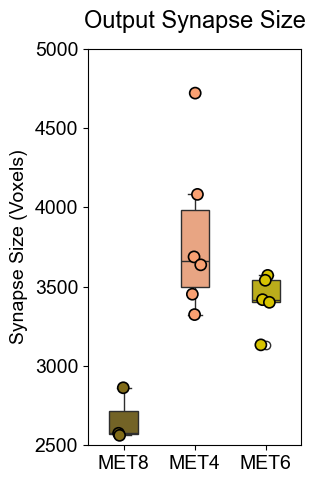

In [35]:
###plotting synapse size/number/connection differences
plt.rcParams["figure.figsize"] = (2.75,5.15)

met_color = ['#806B19', '#f9a072','#D6C300']
#4th  met [, '#FFDF11']
ordermet = ["MET8", "MET4", "MET6"]
afont = {'fontname':'Arial'}

ax =sns.boxplot(x = "met", y = "size", palette = met_color, data = allcell_mean,width = 0.4, order = ordermet)
sns.stripplot(x = "met", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = allcell_mean, marker = 'o', ax = ax, order = ordermet)


plt.title('Output Synapse Size', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('Synapse Size (Voxels)', fontsize = 14, **afont)
# ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])
plt.ylim(2500, 5000)
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

# plt.rcParams["figure.figsize"] = (3.3,4.95)
t = ax.yaxis.get_offset_text()
t.set_size(14)

# plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/Output_syn_size_3met_022224.pdf', bbox_inches = 'tight', transparent = 'True')
plt.show()

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2653691115.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.boxplot(x = "met", y = "size", palette = met_color, data = allcell_count, width = 0.4, order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2653691115.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = "met", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = allcell_count, marker = 'o', ax = ax, order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2653691115.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["MET-8", "MET-4", "

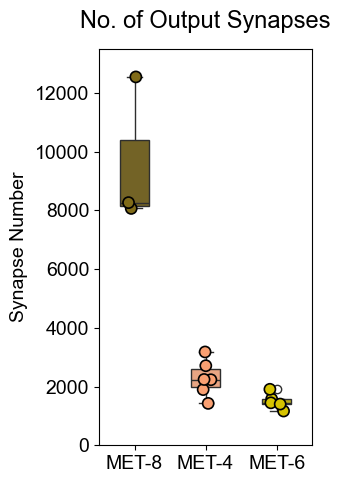

In [36]:
plt.rcParams["figure.figsize"] = (2.75,5.15)

met_color = ['#806B19', '#f9a072','#D6C300']
ax =sns.boxplot(x = "met", y = "size", palette = met_color, data = allcell_count, width = 0.4, order = ordermet)
sns.stripplot(x = "met", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = allcell_count, marker = 'o', ax = ax, order = ordermet)


afont = {'fontname':'Arial'}
plt.title('No. of Output Synapses', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('Synapse Number', fontsize = 14, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.ylim(0, 13500)
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(14)

# plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/No_output_syn_3met_022224.pdf', bbox_inches = 'tight', transparent = 'True')
plt.show()

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2191241399.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.boxplot(x = "met_type", y = "size", palette = met_color, data = met846_synbytarget, width = 0.4,order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2191241399.py:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax =sns.boxplot(x = "met_type", y = "size", palette = met_color, data = met846_synbytarget, width = 0.4,order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2191241399.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = "met_type", y = "size", palette = met_color, edgecolo

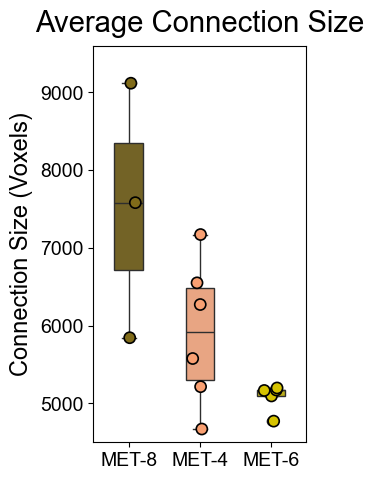

In [43]:
plt.rcParams["figure.figsize"] = (2.75,5.15)

met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
ax =sns.boxplot(x = "met_type", y = "size", palette = met_color, data = met846_synbytarget, width = 0.4,order = ordermet)
sns.stripplot(x = "met_type", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = met846_synbytarget, marker = 'o', ax = ax, order = ordermet)


afont = {'fontname':'Arial'}
plt.title('Average Connection Size', fontsize = 21, **afont, pad = 10)
ax.set_ylabel('Connection Size (Voxels)', fontsize = 17, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.ylim(4500, 9600)
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(20)

# plt.savefig('Avg_cxn_size_3met_090324.pdf', bbox_inches = 'tight', transparent = 'True')
plt.show()

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2437272742.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.boxplot(x = "met_type", y = "no_of_somas", palette = met_color, linewidth = 1.2, data = met846_synbytarget, width = 0.4,order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2437272742.py:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax =sns.boxplot(x = "met_type", y = "no_of_somas", palette = met_color, linewidth = 1.2, data = met846_synbytarget, width = 0.4,order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2437272742.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = "met_

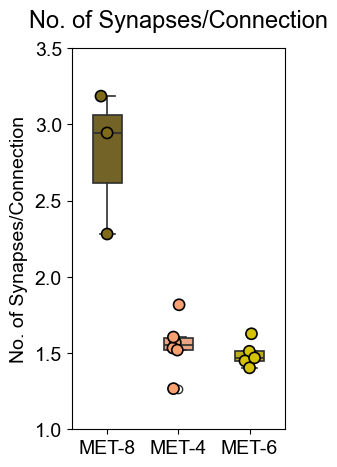

In [22]:
plt.rcParams["figure.figsize"] = (2.75,4.95)

met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
ax =sns.boxplot(x = "met_type", y = "no_of_somas", palette = met_color, linewidth = 1.2, data = met846_synbytarget, width = 0.4,order = ordermet)
sns.stripplot(x = "met_type", y = "no_of_somas", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = met846_synbytarget, marker = 'o', ax = ax, order = ordermet)

afont = {'fontname':'Arial'}
plt.title('No. of Synapses/Connection', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('No. of Synapses/Connection', fontsize = 14, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.ylim(1, 3.5)

plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(14)
# plt.savefig('CG_Met846_avg_cxn_syn_070524.pdf', bbox_inches = 'tight', transparent = 'True')
# plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/CG_Met846_avg_cxn_syn_022224.pdf', bbox_inches = 'tight', transparent = 'True')
plt.show()

In [10]:
##creating plots and running stats for myelin

myelin_df = pd.read_csv("/Users/clare/mye_annot_ids_2024.csv")
print (myelin_df)
myelin_df_sub = myelin_df[["Coordinate_1", "Coordinate_2", "mesh_id", "met_type"]].copy()
myelin_df_sub['Coordinate_1'] = myelin_df_sub.Coordinate_1.apply(lambda x: literal_eval(str(x)))
myelin_df_sub['Coordinate_2'] = myelin_df_sub.Coordinate_2.apply(lambda x: literal_eval(str(x)))
myelin_df_sub['mesh_id_full'] = myelin_df_sub['mesh_id'].str.rstrip(',')

data1 = myelin_df_sub[['mesh_id_full', "met_type"]].drop_duplicates()
coord1_np = np.stack(myelin_df_sub["Coordinate_1"].to_numpy())
coord2_np = np.stack(myelin_df_sub["Coordinate_2"].to_numpy())
coord1_um = coord1_np*[.004,.004,.04]
coord2_um = coord2_np*[.004,.004,.04]
distum = np.linalg.norm(coord1_um - coord2_um ,axis=1)
myelin_df_sub['euc_dist_um'] = distum


##number of segments
mye_id_size = myelin_df_sub.groupby(['mesh_id_full', 'met_type']).size().reset_index()
mye_id_size =mye_id_size.rename(columns={0: "count"})
add0_mye = {'mesh_id_full': '864691136116457636', 'met_type': 'MET6', 'count': 0}
mye_id_size = mye_id_size.append(add0_mye, ignore_index = True)
# print (mye_id_size)

##total length of segments
mye_id_sum =  myelin_df_sub.groupby(['mesh_id_full', 'met_type']).sum().reset_index()
add0_mye_sum = {'mesh_id_full': '864691136116457636', 'met_type': 'MET6', 'euc_dist_um': 0}
mye_id_sum = mye_id_sum.append(add0_mye_sum, ignore_index = True)
# print (mye_id_sum)

###avg length of segment
mye_id_avg =  myelin_df_sub.groupby(['mesh_id_full', 'met_type']).mean().reset_index()
# print (mye_id_avg)


#new
# ###max y-extent of segments
mesh_id_list = ["864691135544588584",
"864691135577202181",
"864691135785592004",
"864691136238652476",
"864691135969447781",
"864691135572082925",
"864691136195284556",
"864691136118647832",
"864691135699487522",
"864691136618564493",
"864691135013417622",
"864691135118298333",
"864691135697251738",
"864691135404765166",
"864691135341516741"]



               Coordinate_1             Coordinate_2                 coord1  \
0   [127859, 173510, 18894]  [127272, 168274, 18794]  127859, 173510, 18894   
1   [151620, 174970, 18354]  [152422, 169262, 18464]  151620, 174970, 18354   
2   [152990, 158753, 18529]  [152043, 152119, 18495]  152990, 158753, 18529   
3   [151948, 151816, 18495]  [151884, 147860, 18491]  151948, 151816, 18495   
4   [151977, 147490, 18507]  [150243, 138016, 18524]  151977, 147490, 18507   
..                      ...                      ...                    ...   
63  [241816, 157490, 24056]  [240996, 147247, 24012]  241816, 157490, 24056   
64  [240014, 135445, 24035]  [239880, 127692, 23997]  240014, 135445, 24035   
65  [239918, 127279, 24002]  [240425, 121001, 23983]  239918, 127279, 24002   
66  [240362, 120418, 23987]  [241153, 115195, 23952]  240362, 120418, 23987   
67  [242023, 107697, 23743]  [243714, 100533, 23453]  242023, 107697, 23743   

                   coord2         coord1_nocom     

In [12]:
####statistics of myelin segment number and y-extent by met type

# ###segment number
print ("")
print ("segment number stats")
mean_met8 = mye_id_size.loc[mye_id_size['met_type'] == 'MET8']
mean_met8_size = mean_met8['count']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
mean_met4 = mye_id_size.loc[mye_id_size['met_type'] == 'MET4']
mean_met4_size = mean_met4['count']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
mean_met6 = mye_id_size.loc[mye_id_size['met_type'] == 'MET6']
mean_met6_size = mean_met6['count']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)

# # ###length
print ("")
print ("length of myelin stats")

mean_met8 = mye_id_sum.loc[mye_id_sum['met_type'] == 'MET8']
mean_met8_size = mean_met8['euc_dist_um']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
mean_met4 = mye_id_sum.loc[mye_id_sum['met_type'] == 'MET4']
mean_met4_size = mean_met4['euc_dist_um']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
mean_met6 = mye_id_sum.loc[mye_id_sum['met_type'] == 'MET6']
mean_met6_size = mean_met6['euc_dist_um']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)


### avg length of myelin
print (" ")
print ("avg length of myelin")

mean_met8 = mye_id_avg.loc[mye_id_avg['met_type'] == 'MET8']
mean_met8_size = mean_met8['euc_dist_um']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
mean_met4 = mye_id_avg.loc[mye_id_avg['met_type'] == 'MET4']
mean_met4_size = mean_met4['euc_dist_um']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
mean_met6 = mye_id_avg.loc[mye_id_avg['met_type'] == 'MET6']
mean_met6_size = mean_met6['euc_dist_um']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)


segment number stats
[1 1 6]
[11  2  8  7  6  6]
[1 1 4 1 0]
KruskalResult(statistic=8.125754060324827, pvalue=0.017199464486342096)
          1         2         3
1  1.000000  0.072901  1.000000
2  0.072901  1.000000  0.004903
3  1.000000  0.004903  1.000000

length of myelin stats
[ 21.45143911  21.35179056 163.10834826]
[348.2114798   34.6885744  220.39757974 165.65482408 276.18548408
 288.90490776]
[ 28.57962155  21.69338406 109.93962454  19.73042726   0.        ]
KruskalResult(statistic=8.159999999999997, pvalue=0.0169074656527053)
          1         2         3
1  1.000000  0.038035  1.000000
2  0.038035  1.000000  0.005975
3  1.000000  0.005975  1.000000
 
avg length of myelin
[21.45143911 21.35179056 27.18472471]
[31.65558907 17.3442872  27.54969747 23.66497487 46.03091401 48.15081796]
[28.57962155 21.69338406 27.48490614 19.73042726]
KruskalResult(statistic=2.324175824175825, pvalue=0.31283233212304246)
          1         2    3
1  1.000000  0.511637  1.0
2  0.511637  1.00

             count       sem
met_type                    
MET8      2.666667  1.666667
MET4      6.666667  1.201850
MET6      1.400000  0.678233


/Applications/anaconda3/envs/CG_EM_paper/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


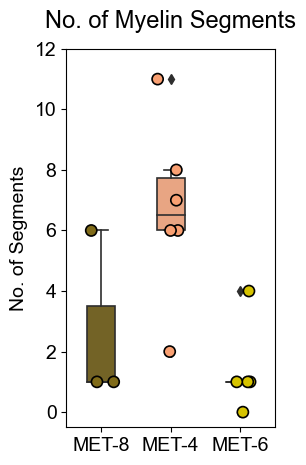

In [18]:
ordermet = ["MET8", "MET4", "MET6"]
plt.rcParams["figure.figsize"] = (2.95,4.75)

####number of myelin segment
seg_no_mean = mye_id_size.groupby('met_type').mean()
seg_no_sem = mye_id_size.groupby('met_type').sem()
seg_no_mean["sem"] = seg_no_sem["count"]
seg_no_mean = seg_no_mean.reindex(["MET8", "MET4", "MET6"])
print (seg_no_mean)



# # # # ####plot # of myelin segments
met_color = ['#806B19', '#f9a072','#D6C300']
met_colorcg = ['#8dd3c7','#ffffb3','#bebada']
plt.figure()

ax =sns.boxplot(x = "met_type", y = "count", palette = met_color, linewidth = 1.2, data = mye_id_size, width = 0.4, order = ordermet)
sns.stripplot(x = "met_type", y = "count", palette = met_color, edgecolor = "black", jitter = 0.2, linewidth = 1.2, s = 8, data = mye_id_size, marker = 'o', ax = ax, order = ordermet)

afont = {'fontname':'Arial'}
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)
plt.ylim(-0.5, 12)
# ax.get_legend().remove()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
t = ax.yaxis.get_offset_text()
t.set_size(14)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])


ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5



plt.title('No. of Myelin Segments', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('No. of Segments', fontsize = 14, **afont)

plt.tight_layout()
# plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/Avg_met_reord_mye_no_seg_sem_17_metcolor_022224', bbox_inches = 'tight', transparent = 'True')


          euc_dist_um        sem
met_type                        
MET8        68.637193  47.235587
MET4       222.340475  45.315153
MET6        35.988611  19.088619


/Applications/anaconda3/envs/CG_EM_paper/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  


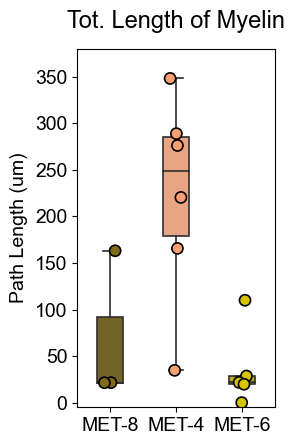

In [21]:
# ##########
# ###euclidean distance of myelin
euc_dist_mean = mye_id_sum.groupby('met_type').mean()
euc_dist_sem = mye_id_sum.groupby('met_type').sem()
euc_dist_mean["sem"] = euc_dist_sem["euc_dist_um"]
euc_dist_mean = euc_dist_mean.reindex(["MET8", "MET4", "MET6"])
print (euc_dist_mean)



# # # # # ####plot total length of myelin
plt.figure()
plt.rcParams["figure.figsize"] = (2.95,4.55)

ax2 =sns.boxplot(x = "met_type", y = "euc_dist_um", palette = met_color, data = mye_id_sum, linewidth = 1.2, width = 0.4, order = ordermet)
sns.stripplot(x = "met_type", y = "euc_dist_um", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = mye_id_sum, marker = 'o', ax = ax2, order = ordermet)

afont = {'fontname':'Arial'}
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax2.set_xlabel('', fontsize = 14, **afont)
# ax2.get_legend().remove()
ax2.xaxis.labelpad = 10
ax2.yaxis.labelpad = 5
plt.ylim(-5, 380)
t = ax.yaxis.get_offset_text()
t.set_size(14)
ax2.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.title('Tot. Length of Myelin', fontsize = 17, **afont, pad = 15)
ax2.set_ylabel('Path Length (um)', fontsize = 14, **afont)

plt.tight_layout()
# plt.savefig('Avg_met_reord_mye_euc_dist_um_17_metcolor_bbatch_1114.pdf', bbox_inches = 'tight', transparent = 'True')

# plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/Avg_met_reord_mye_euc_dist_um_17_metcolor_022224', bbox_inches = 'tight', transparent = 'True')


          euc_dist_um       sem
met_type                       
MET8        23.329318  1.927918
MET4        32.399380  5.036351
MET6        24.372085  2.162434


/Applications/anaconda3/envs/CG_EM_paper/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  del sys.path[0]


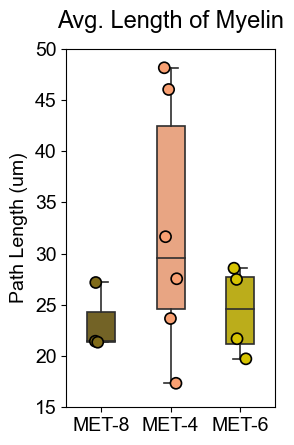

In [22]:
# ###Avg myelin length 
####number of myelin segment
seg_len_mean = mye_id_avg.groupby('met_type').mean()
seg_len_sem = mye_id_avg.groupby('met_type').sem()
seg_len_mean["sem"] = seg_len_sem["euc_dist_um"]
seg_len_mean = seg_len_mean.reindex(["MET8", "MET4", "MET6"])
print (seg_len_mean)
####plot average length of myelin
plt.figure()
plt.rcParams["figure.figsize"] = (2.95,4.55)

ax3 =sns.boxplot(x = "met_type", y = "euc_dist_um", palette = met_color, data = mye_id_avg, linewidth = 1.2, width = 0.4, order = ordermet)
sns.stripplot(x = "met_type", y = "euc_dist_um", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = mye_id_avg, marker = 'o', ax = ax3, order = ordermet)

afont = {'fontname':'Arial'}
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax3.set_xlabel('', fontsize = 14, **afont)
# ax2.get_legend().remove()
ax3.xaxis.labelpad = 10
ax3.yaxis.labelpad = 5
plt.ylim(15, 50)
t = ax.yaxis.get_offset_text()
t.set_size(14)
ax3.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.title('Avg. Length of Myelin', fontsize = 17, **afont, pad = 15)
ax3.set_ylabel('Path Length (um)', fontsize = 14, **afont)

plt.tight_layout()
# plt.savefig('Avg_met_reord_mye_segment_um_17_metcolor_bbatch_1114.pdf', bbox_inches = 'tight', transparent = 'True')
# plt.savefig('/Volumes/My Passport for Mac/minnie_paper/Images/Plots/Avg_met_reord_mye_segment_um_17_metcolor_022224', bbox_inches = 'tight', transparent = 'True')


               Cell ID Predicted MET-type  Reliability  Total_syn  \
0   864691135013417622          Sst-MET-4          1.0     2359.0   
4   864691135544588584          Sst-MET-8          1.0    10043.0   
5   864691135572082925          Sst-MET-8          1.0     9483.0   
8   864691135699487522          Sst-MET-8          1.0    14019.0   
10  864691135969447781          Sst-MET-4          1.0     3783.0   

        Axonleng  Syn_per_axonleng    met  
0    8746.153809          0.269719  MET-4  
4   19494.865754          0.515161  MET-8  
5   18873.727885          0.502444  MET-8  
8   23863.310946          0.587471  MET-8  
10  19306.507595          0.195944  MET-4  


C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2644652030.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.boxplot(x = "met", y = "Syn_per_axonleng", palette = met_color, data = cur_ssts_pred_rename, width = 0.4, order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2644652030.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = "met", y = "Syn_per_axonleng", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = cur_ssts_pred_rename, marker = 'o', ax = ax, order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2644652030.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  

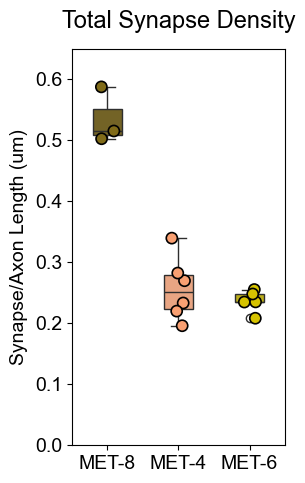

syn per axon length
[0.51516128 0.50244446 0.58747087]
0.5350255358848273

[0.26971856 0.19594429 0.23324393 0.28230767 0.21989961 0.33954079]
0.25677580777743275

[0.23477209 0.20823297 0.23502044 0.25527219 0.24799807]
0.23625915147838544
KruskalResult(statistic=6.683809523809522, pvalue=0.0353695229984442)
          1         2        3
1  1.000000  0.037948  0.02552
2  0.037948  1.000000  1.00000
3  0.025520  1.000000  1.00000


C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2644652030.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.boxplot(x = "met", y = "Axonleng", palette = met_color, data = cur_ssts_pred_rename, width = 0.4, order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2644652030.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = "met", y = "Axonleng", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = cur_ssts_pred_rename, marker = 'o', ax = ax, order = ordermet)
C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_2780\2644652030.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklab

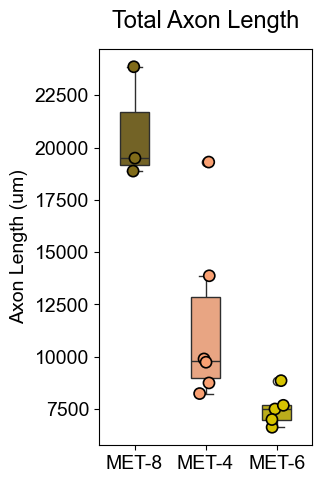


axon length stats
[19494.86575433 18873.72788464 23863.31094573]
20743.968194899775
[ 8746.15380937 19306.50759515 13869.60004397  9893.4613332
  9736.26110214  8237.59645017]
11631.596722332892
[7500.89150248 6627.19273216 7675.92818906 6996.45350078 8854.90756416]
7531.074697728871
KruskalResult(statistic=9.617142857142852, pvalue=0.0081595078153512)
          1         2         3
1  1.000000  0.068779  0.000585
2  0.068779  1.000000  0.014602
3  0.000585  0.014602  1.000000


In [28]:
plt.rcParams["figure.figsize"] = (2.75,5.15)

cur_ssts_pred_rename["met"] = cur_ssts_pred_rename["Predicted MET-type"].str.strip('Sst-')
print (cur_ssts_pred_rename.head())

ordermet = ["MET-8", "MET-4", "MET-6"]

met_color = ['#806B19', '#f9a072','#D6C300']
ax =sns.boxplot(x = "met", y = "Syn_per_axonleng", palette = met_color, data = cur_ssts_pred_rename, width = 0.4, order = ordermet)
sns.stripplot(x = "met", y = "Syn_per_axonleng", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = cur_ssts_pred_rename, marker = 'o', ax = ax, order = ordermet)


afont = {'fontname':'Arial'}
plt.title('Total Synapse Density', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('Synapse/Axon Length (um)', fontsize = 14, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.ylim(0, 0.65)
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(14)

# plt.savefig('No_output_synper_axonlen_3met_090324.pdf', bbox_inches = 'tight', transparent = 'True')
plt.show()

print ('syn per axon length')
mean_met8 = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['met'] == 'MET-8']
mean_met8_size = mean_met8['Syn_per_axonleng']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
print (np_met8.mean())
print ("")
mean_met4 = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['met'] == 'MET-4']
mean_met4_size = mean_met4['Syn_per_axonleng']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
print (np_met4.mean())
print ("")
mean_met6 = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['met'] == 'MET-6']
mean_met6_size = mean_met6['Syn_per_axonleng']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
print (np_met6.mean())
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)


met_color = ['#806B19', '#f9a072','#D6C300']
ax =sns.boxplot(x = "met", y = "Axonleng", palette = met_color, data = cur_ssts_pred_rename, width = 0.4, order = ordermet)
sns.stripplot(x = "met", y = "Axonleng", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = cur_ssts_pred_rename, marker = 'o', ax = ax, order = ordermet)


afont = {'fontname':'Arial'}
plt.title('Total Axon Length', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('Axon Length (um)', fontsize = 14, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

# plt.ylim(0, 13500)
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(14)

# plt.savefig('Axon_len_3met_062024.pdf', bbox_inches = 'tight', transparent = 'True')
plt.show()

print ("")
print ("axon length stats")
mean_met8 = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['met'] == 'MET-8']
mean_met8_size = mean_met8['Axonleng']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
print (np_met8.mean())
mean_met4 = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['met'] == 'MET-4']
mean_met4_size = mean_met4['Axonleng']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
print (np_met4.mean())
mean_met6 = cur_ssts_pred_rename.loc[cur_ssts_pred_rename['met'] == 'MET-6']
mean_met6_size = mean_met6['Axonleng']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
print (np_met6.mean())
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)
